In [2]:

import numpy as np

# randomly generate data 
N = 2 # number of training sample 
d = 2 # data dimension 
C = 3 # number of classes 

X = np.random.randn(d, N)
y = np.random.randint(0, 3, (N,))

In [3]:
import numpy as np
z = np.array([1, 2, 3, 4, 5, 1, 2])

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

softmax(z)  

array([0.01117202, 0.03036871, 0.0825507 , 0.22439607, 0.60997177,
       0.01117202, 0.03036871])

In [4]:
## One-hot coding
from scipy import sparse 
def convert_labels(y, C = C):
    """
    convert 1d label to a matrix label: each column of this 
    matrix coresponding to 1 element in y. In i-th column of Y, 
    only one non-zeros element located in the y[i]-th position, 
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), 
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

Y = convert_labels(y, C)

In [5]:
# cost or loss function  
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))

W_init = np.random.randn(d, C)

def grad(X, Y, W):
    A = softmax((W.T.dot(X)))
    E = A - Y
    return X.dot(E.T)
    
def numerical_grad(X, Y, W, cost):
    eps = 1e-6
    g = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_p = W.copy()
            W_n = W.copy()
            W_p[i, j] += eps 
            W_n[i, j] -= eps
            g[i,j] = (cost(X, Y, W_p) - cost(X, Y, W_n))/(2*eps)
    return g 

g1 = grad(X, Y, W_init)
g2 = numerical_grad(X, Y, W_init, cost)

print(np.linalg.norm(g1 - g2))

8.223918150618603e-10


In [6]:
def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 10000):
    W = [W_init]    
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]
    
    count = 0
    check_w_after = 20
    while count < max_count:
        # mix data 
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count%check_w_after == 0:                
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W
eta = .05 
d = X.shape[0]
W_init = np.random.randn(d, C)

W = softmax_regression(X, y, W_init, eta)
# W[-1] is the solution, W is all history of weights

In [7]:
def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [8]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

# each column is a datapoint
X = np.concatenate((X0, X1, X2), axis = 0).T 
# extended data
X = np.concatenate((np.ones((1, 3*N)), X), axis = 0)
C = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In [9]:
W_init = np.random.randn(X.shape[0], C)
W = softmax_regression(X, original_label, W_init, eta)
print(W[-1])

[[ 8.55982057 -3.30006943 -3.4136539 ]
 [-1.1334429   1.6674008  -0.86542389]
 [ 0.33249063 -0.18545264  3.18461325]]


In [10]:
from sklearn import linear_model

In [11]:
linear_model.LogisticRegression(C=1e5, solver = 'lbfgs', multi_class = 'multinomial')

LogisticRegression(C=100000.0, multi_class='multinomial')

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Chuẩn bị dữ liệu
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# 2. Xây dựng mô hình Softmax
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)  # Lớp fully connected

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten ảnh
        z = self.fc(x)  # Tính toán logits
        return z

# Hàm softmax thủ công
def softmax(z):
    e_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return e_z / torch.sum(e_z, dim=1, keepdim=True)

# Khởi tạo mô hình
input_size = 3 * 32 * 32  # CIFAR-10 có kích thước ảnh 32x32x3
num_classes = 10  # 10 lớp
model = SoftmaxClassifier(input_size, num_classes)

# 3. Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Huấn luyện mô hình
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        logits = model(inputs)
        
        # Tính toán hàm mất mát
        loss = criterion(logits, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

# 5. Đánh giá mô hình trên tập kiểm tra
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        logits = model(inputs)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 1.8659610905305808
Epoch 2/10, Loss: 1.7933086159893923
Epoch 3/10, Loss: 1.776132618984603
Epoch 4/10, Loss: 1.7599455624285256
Epoch 5/10, Loss: 1.7519198941147847
Epoch 6/10, Loss: 1.748296865264473
Epoch 7/10, Loss: 1.7418917554723636
Epoch 8/10, Loss: 1.7378809825538675
Epoch 9/10, Loss: 1.7309358049841488
Epoch 10/10, Loss: 1.7312905895130715
Accuracy on test set: 37.1%


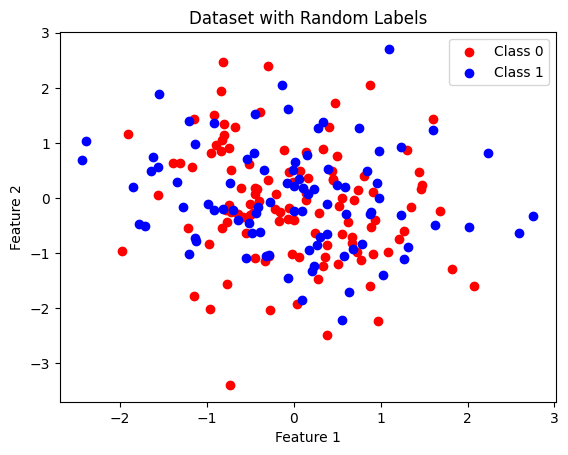

Dữ liệu:
tensor([[ 0.6957, -0.0405],
        [ 1.8169, -1.2922],
        [ 2.2333,  0.8197],
        [ 0.3583, -1.0678],
        [ 0.3807, -0.8525]])
Nhãn:
tensor([0, 0, 1, 0, 0])


In [13]:
import torch
import matplotlib.pyplot as plt

# Thiết lập các tham số
num_samples_per_class = 100  # Số mẫu cho mỗi lớp
num_features = 2  # Số chiều của đặc trưng (features)
num_samples = num_samples_per_class * 2  # Tổng số mẫu (2 lớp)

# Tạo dữ liệu ngẫu nhiên cho 2 lớp (dùng phân phối chuẩn)
data = torch.randn(num_samples, num_features)  # Tạo dữ liệu ngẫu nhiên (2 chiều)

# Gán nhãn ngẫu nhiên (0 hoặc 1)
labels = torch.randint(0, 2, (num_samples,))  # Gán nhãn ngẫu nhiên (0 hoặc 1)

# Vẽ dữ liệu
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], color='red', label='Class 0')
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Dataset with Random Labels')
plt.show()

# In ra một phần của dữ liệu và nhãn
print("Dữ liệu:")
print(data[:5])  # In 5 mẫu đầu tiên của dữ liệu
print("Nhãn:")
print(labels[:5])  # In 5 nhãn đầu tiên
